<a href="https://colab.research.google.com/github/WilliamPoe/CSCI-290/blob/main/notebooks/k_means_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FixedLocator, FixedFormatter

In [25]:
from os import major
class KMeans_clustering:

    def __init__(self, k=3, method = 'random', plot = False, max_iterations=100):
      self.k = k
      self.method = method
      self.plot = plot
      self.max_iterations = max_iterations

      if not self.plot:
        print('Plotting Disabled!')
      else:
        print('Plotting Enabled!')

    def euclidean_distance(self, point1, point2): # Calculate the euclidean distance
      return np.sqrt(np.sum((np.array(point1) - np.array(point2))**2))

    def silhouette_coefficients_calc(self, data): # Calculates the silhouette coefficients
      silhouette_scores = []

      for idx in range(data.shape[0]):
        current_label = self.labels[idx]
        current_cluster = self.clusters[current_label]

        if len(current_cluster) > 1:
          cohesion = np.mean([self.euclidean_distance(data.iloc[idx], data.iloc[point]) for point in current_cluster if point != idx])
        else:
          cohesion = 0

        seperation = float('inf')
        for cluster_idx, other_cluster in enumerate(self.clusters):
          if cluster_idx != current_label:
            seperation_distance = np.mean([self.euclidean_distance(data.iloc[idx], data.iloc[point]) for point in other_cluster])
            seperation = min(seperation, seperation_distance)

        silhouette = (seperation - cohesion) / max(cohesion, seperation) if max(cohesion, seperation) > 0 else 0
        silhouette_scores.append(silhouette)

      return np.mean(silhouette_scores), silhouette_scores

    def silhouette_coefficient(self, data, k_values): # Calculate the silhouette coefficient for k values and plots
      silhouette_scores = []
      all_silhouette_values = []

      for k in k_values:
        self.k = k
        self.fit(data)

        avg_silhouette, point_silhouette_scores = self.silhouette_coefficients_calc(data)
        silhouette_scores.append(avg_silhouette)
        all_silhouette_values.append(point_silhouette_scores)

        print(f'Silhouette coefficient for k={k}: {avg_silhouette}')

      plt.figure(figsize=(11, 9))
      for idx, k in enumerate(k_values):
        plt.subplot(2, 2, k - 2)

        point_silhouettes = np.array(all_silhouette_values[idx])
        y_pred = np.array(self.labels)

        padding = len(data) // 30
        pos = padding
        ticks = []
        for cluster_idx in range(k):
          coeffs = point_silhouettes[y_pred == cluster_idx]
          coeffs.sort()

          color = plt.cm.Spectral(cluster_idx / k)
          plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
          ticks.append(pos + len(coeffs) // 2)
          pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))

        if k in (3, 5):
          plt.ylabel("Cluster")

        if k in (5, 6):
          plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
          plt.xlabel("Silhouette Coefficient")

        else:
          plt.tick_params(labelbottom=False)

        plt.axvline(x=silhouette_scores[idx], color="red", linestyle="--")
        plt.title(f"$k={k}$")

      plt.suptitle("Silhouette Analysis", fontsize=16)
      plt.show()

    def ran_centroids(self, data): # Picks random centroids from dataset
      ran_centroids = data.sample(self.k).index
      return data.loc[ran_centroids]

    def centroid_selection(self, data): # Selects centroids far apart from each other
      centroids = pd.DataFrame(columns=data.columns, index=range(self.k))
      centroids.iloc[0] = data.sample(1).index
      for i in range(self.k):
        distances = []
        for idx, point in data.iterrows():
          near_distances = min([self.euclidean_distance(point, centroid) for _, centroid in centroids.iterrows()])
          distances.append(near_distances)
        centroids.iloc[i] = data.iloc[np.argmax(distances)]
      return centroids

    def calc_centroids(self, clusters, data): # Calculate the new centroids from the clusters
      centroids = pd.DataFrame(columns=data.columns, index=range(self.k))
      for i, cluster in enumerate(clusters):
        centroids.iloc[i] = np.mean(data.iloc[[idx for idx in cluster]], axis=0)
      return centroids

    def distances(self, point, centroids): # Calculate the distance between the data and the centroids using euclidean distances function
      distances = [self.euclidean_distance(point, centroid) for _, centroid in centroids.iterrows()]
      return np.argmin(distances)

    def clustering(self, data, centroids): # Clusters the data together based off of the calculated distances
      clusters = [[] for _ in range(self.k)]
      labels = np.empty(self.n_samples, dtype=int) # added change here
      for idx in range(data.shape[0]):
        point = data.iloc[idx]
        cluster_index = self.distances(point, centroids)
        clusters[cluster_index].append(idx)
        labels[idx] = cluster_index
      return clusters, labels

    def accuracy(self, true_labels):
      majority_labels = {}
      for cluster in range(self.k):
        cluster_points = [idx for idx, label in enumerate(self.labels) if label == cluster]
        t_cluster_labels = [true_labels[idx] for idx in cluster_points]

        majority_label = max(set(t_cluster_labels), key=t_cluster_labels.count)
        majority_labels[cluster] = majority_label

      correct_predictions = sum(majority_labels[label] == true_labels[idx] for idx, label in enumerate(self.labels))
      accuracy = correct_predictions / self.n_samples
      return accuracy

    def fit(self, data): # Fits the data
      self.n_samples, self.n_features = data.shape[0], data.shape[1]
      print('The number of samples is:',self.n_samples)
      print('The number of features is:',self.n_features,'\n')

      if self.method.lower() == 'random':
        self.centroids = self.ran_centroids(data)
      elif self.method.lower() == 'calculated':
        self.centroids = self.centroid_selection(data)
      elif self.method.lower() == 'choice':
        for i in range(self.k):
          idx = int(input('Pick an index for a centroid: '))
          self.centroids.iloc[i] = data.iloc[idx]
      else:
        print('Invalid method')
        return

      for iteration in range(self.max_iterations):
        self.clusters, self.labels = self.clustering(data, self.centroids)
        cur_centroids = self.calc_centroids(self.clusters, data)

        #if (iteration / 10) % 1 == 0 or iteration == 1: if you don't want to plot every iteration

        inertia = 0

        for cluster in range(self.k):
          for point in self.clusters[cluster]:
            inertia += np.sum((data.iloc[point] - cur_centroids.iloc[cluster])**2)
        print('INERTIA for iteration', iteration ,':', inertia)

        if self.plot:

          plt.figure(figsize=(5, 3))

          # Plots the data points with cluster colors
          sns.scatterplot( x = data.iloc[:, 0], y = data.iloc[:, 1], hue = self.labels, palette='viridis')

          # Plots the centroids with a different color
          sns.scatterplot( x = cur_centroids.iloc[:, 0], y = cur_centroids.iloc[:, 1], c = "black", marker="X", s = 100);

          plt.title(f'Cluster Visualization - Iteration {iteration}')
          plt.xlabel('Feature 1')
          plt.ylabel('Feature 2')

          plt.show()

        if self.centroids.equals(cur_centroids.set_index(self.centroids.index)):
          print('The centroids have converged')
          print('The number of iterations is:',iteration)
          break
        self.centroids = cur_centroids

Dataset datatypes:
SepalLengthCm    float64
SepalWidthCm     float64
PetalLengthCm    float64
PetalWidthCm     float64
dtype: object 

Plotting Disabled!
The number of samples is: 150
The number of features is: 4 

INERTIA for iteration 0 : 84.98710634920636
INERTIA for iteration 1 : 79.63090549450543
INERTIA for iteration 2 : 78.94084142614606
INERTIA for iteration 3 : 78.94084142614606
The centroids have converged
The number of iterations is: 3
Silhouette coefficient for k=3: 0.5525919445499755
The number of samples is: 150
The number of features is: 4 

INERTIA for iteration 0 : 77.45390634920636
INERTIA for iteration 1 : 72.03406318681319
INERTIA for iteration 2 : 71.34399911845372
INERTIA for iteration 3 : 71.34399911845372
The centroids have converged
The number of iterations is: 3
Silhouette coefficient for k=4: 0.41684514141972834
The number of samples is: 150
The number of features is: 4 

INERTIA for iteration 0 : 60.19913732193731
INERTIA for iteration 1 : 51.315360576923055

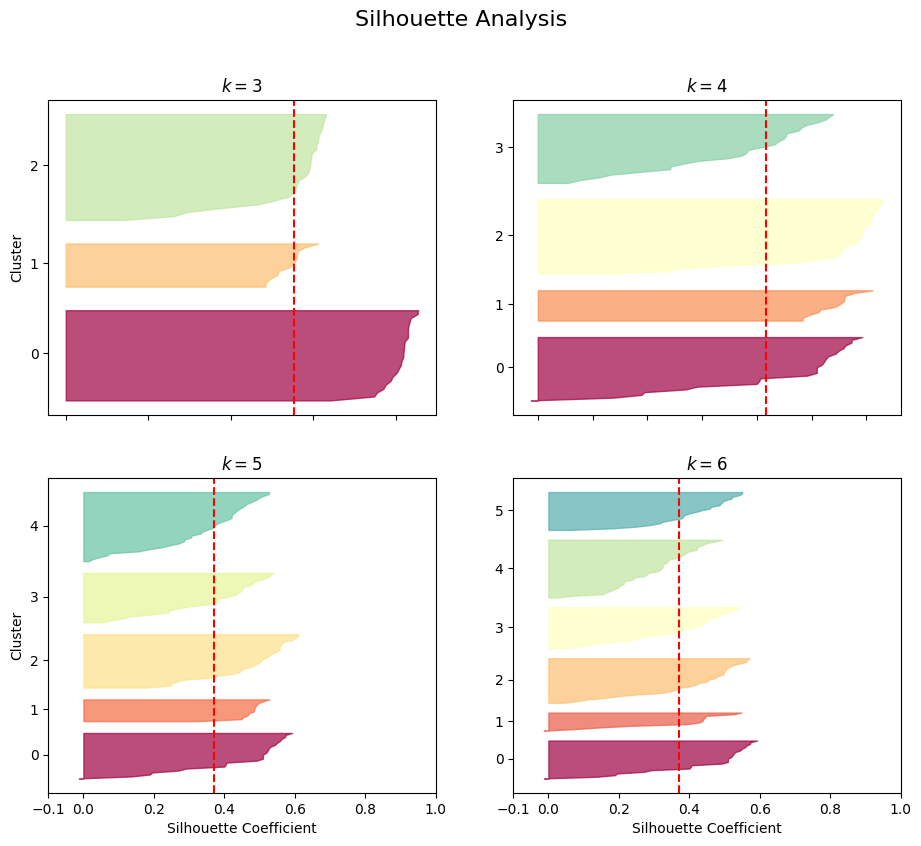

In [26]:
#df = pd.read_csv('https://github.com/WilliamPoe/CSCI-290/raw/refs/heads/main/Data/penguins.csv') # Penguins dataset
df = pd.read_csv('https://github.com/WilliamPoe/CSCI-290/raw/refs/heads/main/Data/Iris.csv') # Iris dataset

numeric_df = df.select_dtypes(include=[np.number])

#numeric_df = numeric_df.drop(columns='year')
numeric_df = numeric_df.drop(columns='Id')
numeric_df = numeric_df.dropna()
print('Dataset datatypes:')
print(numeric_df.dtypes, '\n')

k_values = [3, 4, 5, 6]
model = KMeans_clustering(k=3, method='calculated', plot=False)
model.silhouette_coefficient(numeric_df, k_values)

# centroid options (random, calculated, choice)
#model.fit(numeric_df)
#labels = model.labels
#centroids = model.centroids


In [24]:
#true_labels = df['species'].apply(lambda x: {'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2}[x]).values
true_labels = df['Species'].apply(lambda x: {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}[x]).values

model = KMeans_clustering(k=3, method='calculated', plot=False)
model.fit(numeric_df)
labels = model.labels
centroids = model.centroids

accuracy = model.accuracy(true_labels)
print('Accuracy:', accuracy)

Plotting Disabled!
The number of samples is: 150
The number of features is: 4 

INERTIA for iteration 0 : 84.98710634920636
INERTIA for iteration 1 : 79.63090549450543
INERTIA for iteration 2 : 78.94084142614606
INERTIA for iteration 3 : 78.94084142614606
The centroids have converged
The number of iterations is: 3
Accuracy: 0.8933333333333333
